# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [1]:
import sys
print("Python %s" % sys.version)
import time
import random as rand

Python 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.5


In [3]:
import gym
print("OpenAI Gym %s" % gym.__version__)
from gym import wrappers

OpenAI Gym 0.14.0


In [4]:
import matplotlib
print("matplotlib %s" % matplotlib.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib 3.1.1


In [5]:
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

In [6]:
from IPython import display

In [7]:
# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [8]:
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [9]:
env

<TimeLimit<AtariEnv<PongDeterministic-v4>>>

# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



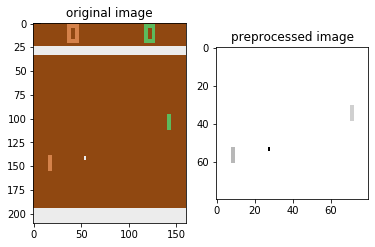

In [10]:
# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)
        self.conv1 = nn.Conv2d(2, 4, kernel_size=5, stride=2, padding=2)
        #self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # output = 40x40 here
        self.conv2 = nn.Conv2d(4, 16, kernel_size=5, stride=2, padding=2)
        #self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        # output = 20x20 here
        self.size=16*20*20
        
        # 2 fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        #x = self.pool1(x)
        x = F.relu(self.conv2(x))
        #x = self.pool2(x)
        # flatten the tensor
        x = x.view(-1, self.size)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.sig(x)

# use your own policy!
policy=Policy().to(device)
# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [12]:
policy

Policy(
  (conv1): Conv2d(2, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=6400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [13]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

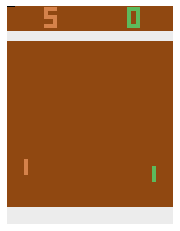

In [14]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

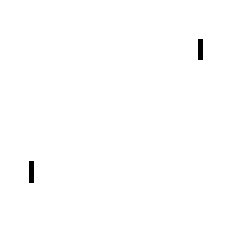

In [15]:
pong_utils.play(env, policy, time=100, preprocess=pong_utils.preprocess_single) 

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [16]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [17]:
print(prob)

[array([0.5201614 , 0.520189  , 0.5201286 , 0.47980043], dtype=float32), array([0.520224 , 0.5204396, 0.5202234, 0.5200796], dtype=float32), array([0.479651 , 0.5203012, 0.520349 , 0.520355 ], dtype=float32), array([0.5206278 , 0.47922793, 0.5207485 , 0.5207485 ], dtype=float32), array([0.5206119 , 0.52054095, 0.5207028 , 0.47929722], dtype=float32), array([0.52005625, 0.5200794 , 0.5201447 , 0.5200299 ], dtype=float32), array([0.5199219 , 0.48017514, 0.48007986, 0.5198983 ], dtype=float32), array([0.48016238, 0.48037153, 0.48027724, 0.5198376 ], dtype=float32), array([0.4798876 , 0.47993335, 0.47999793, 0.5202272 ], dtype=float32), array([0.47996524, 0.47983906, 0.52009857, 0.47974005], dtype=float32), array([0.5201995 , 0.4796005 , 0.52017367, 0.5202459 ], dtype=float32), array([0.5200815 , 0.52041805, 0.47992417, 0.47975323], dtype=float32), array([0.5198069 , 0.48008358, 0.48020214, 0.48005676], dtype=float32), array([0.520849  , 0.5210912 , 0.52074397, 0.4793199 ], dtype=float32),

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [18]:
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    discount = discount ** np.arange(len(rewards))
    rewards = np.asarray(rewards) * discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert to tensor
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs / old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean((rewards * ratio) + (beta * entropy))


Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [19]:
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000 # 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

policy.train()
for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, 
                   discount=discount_rate, beta=beta)
    # L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, 
    #                           discount=discount_rate, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    #bar del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)

policy.eval()
timer.finish()

Episode: 20, score: -14.500000
[-16. -14. -12. -16. -16. -16. -13. -13.]


Episode: 40, score: -13.875000
[-16. -15. -17.  -7. -16. -15.  -8. -17.]


Episode: 60, score: -13.125000
[-15. -13. -16. -12. -12.  -9. -12. -16.]


Episode: 80, score: -15.250000
[-17. -16. -15. -16. -14. -14. -14. -16.]


Episode: 100, score: -11.875000
[ -7. -14. -12. -10. -13. -10. -16. -13.]


Episode: 120, score: -11.750000
[ -8. -10. -10. -14. -12. -10. -14. -16.]


Episode: 140, score: -12.625000
[-16. -11. -14. -12. -14. -10. -13. -11.]


Episode: 160, score: -13.250000
[-15. -13. -16. -16. -13.  -9. -16.  -8.]


Episode: 180, score: -14.625000
[-13. -16. -16. -13. -15. -13. -17. -14.]


Episode: 200, score: -14.000000
[-16. -16. -12. -16. -15. -15. -10. -12.]


Episode: 220, score: -13.250000
[-13. -12. -16. -11. -16. -12. -16. -10.]


Episode: 240, score: -13.375000
[-10. -16. -16. -15. -13. -10. -14. -13.]


Episode: 260, score: -13.750000
[-16. -12. -14. -14. -13. -12. -16. -13.]


Episode: 280, score: -14.375000
[-14. -16. -14. -12. -14. -16. -14. -15.]


Episode: 300, score: -14.000000
[-16. -16. -12. -13. -16. -15. -15.  -9.]


Episode: 320, score: -14.875000
[-16. -15. -16. -16. -16. -12. -14. -14.]


Episode: 340, score: -12.750000
[-13. -14. -16. -11. -14.  -8. -14. -12.]


Episode: 360, score: -13.625000
[-14. -13. -14. -11. -16. -12. -16. -13.]


Episode: 380, score: -11.875000
[-12. -15.  -9.  -8. -13. -13. -14. -11.]


Episode: 400, score: -10.250000
[-10.  -7. -16. -12.  -9.  -8. -12.  -8.]


Episode: 420, score: -11.625000
[-12. -14. -10. -11. -15.  -7. -14. -10.]


Episode: 440, score: -11.500000
[ -7. -10. -15. -11. -15. -13.  -9. -12.]


Episode: 460, score: -11.125000
[-15. -13. -12.  -6. -13. -11.  -7. -12.]


Episode: 480, score: -11.125000
[-10. -12. -13.  -9. -12. -11. -13.  -9.]


Episode: 500, score: -8.500000
[-10. -10.  -7.  -8.  -9.  -8.  -8.  -8.]


Episode: 520, score: -8.000000
[ -9.  -6.  -7.  -8. -11. -10.  -5.  -8.]


Episode: 540, score: -8.000000
[ -5.  -4.  -8.  -9.  -6. -12. -13.  -7.]


Episode: 560, score: -7.250000
[ -8. -10.  -6.  -8.  -7.  -5.  -7.  -7.]


Episode: 580, score: -8.250000
[ -9.  -5. -12.  -8. -12. -10.  -4.  -6.]


Episode: 600, score: -6.125000
[-6. -9. -4. -7. -5. -4. -7. -7.]


Episode: 620, score: -5.250000
[-8. -2. -8. -2. -7. -2. -9. -4.]


Episode: 640, score: -4.250000
[-6. -8. -1. -5. -2. -4. -5. -3.]


Episode: 660, score: -3.750000
[-7. -2. -8. -4. -5. -2. -1. -1.]


Episode: 680, score: -2.000000
[ 0. -3.  1. -5. -7. -1. -1.  0.]


Episode: 700, score: -2.375000
[-1. -4.  0. -1. -1. -3. -8. -1.]


Episode: 720, score: -2.625000
[-1. -6. -2. -2. -1. -2. -2. -5.]


Episode: 740, score: -1.500000
[ 0. -5.  0. -2. -1.  0. -2. -2.]


Episode: 760, score: -1.375000
[-5.  0. -3.  0. -3.  0.  0.  0.]


Episode: 780, score: -0.625000
[ 1. -4.  0.  0.  0.  0. -2.  0.]


Episode: 800, score: -1.750000
[-2. -6. -1. -5.  3.  0.  0. -3.]


Episode: 820, score: 0.750000
[ 0.  2.  1.  0.  1.  0.  3. -1.]


Episode: 840, score: -0.625000
[-4. -5.  0.  0.  2. -2.  1.  3.]


Episode: 860, score: 1.875000
[0. 0. 3. 3. 3. 3. 3. 0.]


Episode: 880, score: 1.375000
[ 2.  3.  2.  3.  3.  3.  0. -5.]


Episode: 900, score: 1.750000
[ 0.  3.  3. -2.  1.  3.  3.  3.]


Episode: 920, score: 0.375000
[ 3.  3.  2.  2.  2. -1. -1. -7.]


Episode: 940, score: 2.750000
[ 3.  5.  3.  5.  3.  3. -3.  3.]


Episode: 960, score: 2.750000
[3. 1. 3. 3. 3. 3. 3. 3.]


Episode: 980, score: 1.875000
[ 3.  3. -2. -2.  3.  3.  3.  4.]


Episode: 1000, score: 3.250000
[4. 3. 3. 4. 5. 3. 0. 4.]


#### CPU Load

![REINFORCE CPU Load](./images/reinforce-cpu-load.png)

#### GPU Load

```
while sleep 0.2; do
nvidia-smi --query-gpu=name,index,temperature.gpu,\
utilization.gpu,utilization.memory,\
memory.total,memory.free,memory.used --format=csv,noheader
done
```

```
GeForce GTX 1060, 0, 64, 7 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 7 %, 3 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 54 %, 20 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 7 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 5 %, 1 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 5 %, 1 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 7 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 64, 7 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 63, 7 %, 1 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 63, 72 %, 25 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 63, 12 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 63, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
GeForce GTX 1060, 0, 63, 6 %, 2 %, 6078 MiB, 4111 MiB, 1967 MiB
```

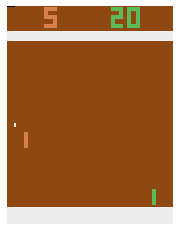

In [20]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

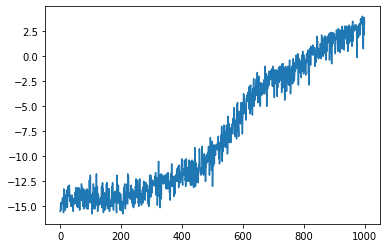

In [21]:
plt.plot(mean_rewards)

In [23]:
# save your policy!
torch.save(policy, 'pong-REINFORCE.policy')

# load your policy if needed
# policy = torch.load('pong-REINFORCE.policy')

# load your policy if needed
# policy = torch.load('pong-REINFORCE_solution.policy')

# try and test out the solution!
# policy = torch.load('pong-PPO_solution.policy')

## Watch a Smart Agent!

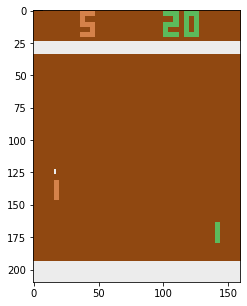

In [24]:
time=2000
nrand=5

plt.figure(figsize=(5,5))
state = env.reset()
env.step(1)
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

# perform nrand random steps in the beginning
for _ in range(nrand):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    env.render()
    frame1, reward1, is_done, _ = env.step(np.random.choice(
        [pong_utils.RIGHT,pong_utils.LEFT]))
    frame2, reward2, is_done, _ = env.step(0)

for _ in range(time):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    frame_input = pong_utils.preprocess_batch([frame1, frame2])
    prob = policy(frame_input)

    env.render()
    # RIGHT = 4, LEFT = 5
    action = pong_utils.RIGHT if rand.random() < prob else pong_utils.LEFT
    frame1, _, is_done, _ = env.step(action)
    frame2, _, is_done, _ = env.step(0)

    if is_done:
        break

env.close()

In [27]:
time=2000
nrand=5

env = wrappers.Monitor(env, "./gym-results-REINFORCE", force=True)
state = env.reset()
env.step(1)
# perform nrand random steps in the beginning
for _ in range(nrand):
    env.render()
    frame1, reward1, is_done, _ = env.step(np.random.choice(
        [pong_utils.RIGHT,pong_utils.LEFT]))
    frame2, reward2, is_done, _ = env.step(0)

for _ in range(time):
    frame_input = pong_utils.preprocess_batch([frame1, frame2])
    prob = policy(frame_input)

    env.render()
    # RIGHT = 4, LEFT = 5
    action = pong_utils.RIGHT if rand.random() < prob else pong_utils.LEFT
    frame1, _, is_done, _ = env.step(action)
    frame2, _, is_done, _ = env.step(0)

    if is_done:
        break

env.close()

Convert mp4 file to GIF.

In [28]:
%%bash
ls -l ./gym-results-REINFORCE

total 176
-rw-r--r-- 1 eka eka    161 Oct 10 10:21 openaigym.episode_batch.2.5246.stats.json
-rw-r--r-- 1 eka eka    231 Oct 10 10:21 openaigym.manifest.2.5246.manifest.json
-rw-r--r-- 1 eka eka   2130 Oct 10 10:21 openaigym.video.2.5246.video000000.meta.json
-rw-r--r-- 1 eka eka 164154 Oct 10 10:21 openaigym.video.2.5246.video000000.mp4


In [29]:
%%bash
ffmpeg -i ./gym-results-REINFORCE/openaigym.video.2.5246.video000000.mp4 ./gifs-REINFORCE/001.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

## Hardware Specifications and Software Versions

In [30]:
%%bash
cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [31]:
%%bash
nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [32]:
%%bash
nvidia-smi

Thu Oct 10 10:21:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P3    23W /  N/A |   1957MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [33]:
%%bash
pip freeze

atari-py==0.2.6
attrs==19.1.0
backcall==0.1.0
bleach==3.1.0
box2d-py==2.3.8
certifi==2019.6.16
cffi==1.12.3
cloudpickle==1.2.2
cycler==0.10.0
Cython==0.29.13
decorator==4.4.0
defusedxml==0.6.0
entrypoints==0.3
future==0.17.1
glfw==1.8.3
gym==0.14.0
imageio==2.5.0
ipykernel==5.1.2
ipython==7.8.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.15.1
Jinja2==2.10.1
jsonschema==3.0.2
jupyter==1.0.0
jupyter-client==5.3.1
jupyter-console==6.0.0
jupyter-core==4.5.0
kiwisolver==1.1.0
lockfile==0.12.2
MarkupSafe==1.1.1
matplotlib==3.1.1
mistune==0.8.4
mkl-fft==1.0.14
mkl-random==1.0.2
mkl-service==2.3.0
mujoco-py==2.0.2.5
nbconvert==5.5.0
nbformat==4.4.0
notebook==6.0.1
numpy==1.16.5
olefile==0.46
opencv-python==4.1.1.26
pandocfilters==1.4.2
parso==0.5.1
pexpect==4.7.0
pickleshare==0.7.5
Pillow==6.1.0
progressbar==2.5
prometheus-client==0.7.1
prompt-toolkit==2.0.9
ptyprocess==0.6.0
pycparser==2.19
pyglet==1.3.2
Pygments==2.4.2
pyparsing==2.4.2
pyrsistent==0.14.11
python-dateutil==2.8.0
pytz==2